In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm  # colormaps 
                                        
%matplotlib inline

In [2]:
from sklearn import datasets
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import numpy as np
from statistics import mean
from math import ceil
from collections import OrderedDict

In [3]:
import torch
import torchvision

In [4]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [5]:
from moe_models import moe_stochastic_model, moe_stochastic_loss, moe_expectation_model, moe_pre_softmax_expectation_model

device cpu


In [6]:
from experts_gates import *

In [7]:
dataset = 'checker_board'
num_classes = 2
X = 2 * np.random.random((3000,2)) - 1
def classifier2(X):
    return (np.sum( X * X, axis=1) < 0.66 ).astype(float)
def classifier3(X): # a 3x2 checkerboard pattern
    return (( np.ceil((3/2)*(X[:,0]+1)).astype(int) + np.ceil( X[:,1]+1).astype(int) ) %2).astype(float)
def classifier4(X): # a 4x4 checkerboard pattern -- you can use the same method to make up your own checkerboard patterns
    return (np.sum( np.ceil( 2 * X).astype(int), axis=1 ) % 2).astype(float)
y = classifier4( X ) 

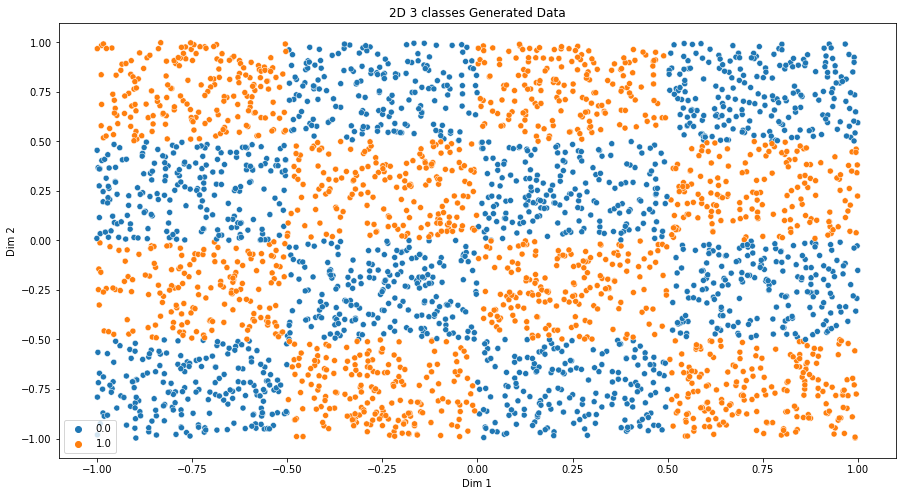

In [8]:
f, ax = plt.subplots(nrows=1, ncols=1,figsize=(15,8))
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:purple'][0:num_classes]
sns.scatterplot(x=X[:,0],y=X[:,1],hue=y,palette=colors, ax=ax)
ax.set_title("2D 3 classes Generated Data")
plt.ylabel('Dim 2')
plt.xlabel('Dim 1')
plt.savefig('figures/all/'+dataset+'_'+str(num_classes)+'_.png')

In [9]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [10]:
print(len(y_train))
print(sum(y_train))
print(len(y_test))
print(sum(y_test))

2400
1152.0
600
288.0


In [11]:
print(len(y_train))

2400


In [12]:
# Create trainloader
batchsize = len(y_train)
trainset = torch.utils.data.TensorDataset(torch.tensor(x_train, dtype=torch.float32), 
                                          torch.tensor(y_train, dtype=torch.long))
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize,
                                        shuffle=True, num_workers=2)
testset = torch.utils.data.TensorDataset(torch.tensor(x_test, dtype=torch.float32),
                                         torch.tensor(y_test, dtype=torch.long))
testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset),
                                        shuffle=True, num_workers=2)

In [13]:
# compute
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [14]:
num_experts = 10
num_epochs = 40

# experiment with models with different number of experts
models = {'moe_stochastic_model':{'model':moe_stochastic_model, 'loss':moe_stochastic_loss,'experts':{}}, 
          'moe_expectation_model':{'model':moe_expectation_model,'loss':nn.CrossEntropyLoss(),'experts':{}}, 
          'moe_pre_softmax_expectation_model':{'model':moe_pre_softmax_expectation_model,'loss':nn.CrossEntropyLoss(),'experts':{}}}

for key, val in models.items():
    print('Model:', key)
    print('Number of experts ', num_experts)
    expert_models = experts(expert_layers, num_experts, num_classes)
    gate_model = gate_layers(num_experts)
    moe_model = val['model'](num_experts, expert_models, gate_model)
    params = [p.numel() for p in moe_model.parameters() if p.requires_grad]
    print('model params:', sum(params))
    optimizer = optim.RMSprop(moe_model.parameters(),
                              lr=0.001, momentum=0.9)
    hist = moe_model.train(trainloader, testloader, optimizer, val['loss'], accuracy, epochs=num_epochs)
    models[key]['experts'][num_experts]={'model':moe_model, 'hist': hist}
    

Model: moe_stochastic_model
Number of experts  10
model params: 282
epoch 0 training loss 0.70 , training accuracy 0.51 , test accuracy 0.52
epoch 1 training loss 0.69 , training accuracy 0.52 , test accuracy 0.53
epoch 2 training loss 0.69 , training accuracy 0.53 , test accuracy 0.52
epoch 3 training loss 0.69 , training accuracy 0.52 , test accuracy 0.53
epoch 4 training loss 0.69 , training accuracy 0.52 , test accuracy 0.52
epoch 5 training loss 0.69 , training accuracy 0.53 , test accuracy 0.52
epoch 6 training loss 0.69 , training accuracy 0.54 , test accuracy 0.50
epoch 7 training loss 0.69 , training accuracy 0.54 , test accuracy 0.54
epoch 8 training loss 0.69 , training accuracy 0.53 , test accuracy 0.52
epoch 9 training loss 0.69 , training accuracy 0.54 , test accuracy 0.49
epoch 10 training loss 0.69 , training accuracy 0.54 , test accuracy 0.53
epoch 11 training loss 0.69 , training accuracy 0.53 , test accuracy 0.50
epoch 12 training loss 0.69 , training accuracy 0.54 ,

In [ ]:
moe_model = models['moe_stochastic_model']['experts'][10]['model']

layer_1_neurons = {}
layer_2_neurons = {}

parameters = moe_model.gate.parameters()
with torch.no_grad():
    for i, parameter in enumerate(parameters, 0):
        if i == 0:
            layer_1_neurons['wts']= parameter#.detach().numpy()
        if i == 1:
            layer_1_neurons['bias'] = parameter#.detach().numpy()
        if i == 2:
            layer_2_neurons['wts']= parameter#.detach().numpy()
        if i == 3:
            layer_2_neurons['bias'] = parameter#.detach().numpy()


In [15]:
print(layer_1_neurons)
print(layer_2_neurons)

{'wts': Parameter containing:
tensor([[ 1.8470,  0.8127],
        [ 0.2432, -0.2899],
        [-0.9546,  0.2574],
        [ 0.1244,  0.2468]], requires_grad=True), 'bias': Parameter containing:
tensor([ 1.2764,  1.4224,  0.9717, -0.4220], requires_grad=True)}
{'wts': Parameter containing:
tensor([[-1.0445, -0.7920, -0.0692, -0.0534],
        [-0.0576, -0.1488, -0.6837, -0.2809],
        [-0.0040,  0.8217,  1.1936,  0.4352],
        [-0.4948, -0.9682, -0.5574, -0.0813],
        [ 1.3848,  1.1187, -0.4424, -0.4910],
        [-0.6900, -0.4794,  0.3794,  0.3859],
        [-0.4495, -0.1908, -0.3652,  0.2807],
        [ 0.0098, -0.9309, -1.0925,  0.2704],
        [-0.4090, -0.2417, -0.2647,  0.3009],
        [-0.9134,  0.1926,  0.3063, -0.2200]], requires_grad=True), 'bias': Parameter containing:
tensor([-0.0022, -0.0295,  1.7074, -0.2970,  1.0077, -0.7356,  0.1492, -0.1691,
         0.1202, -0.2919], requires_grad=True)}


wts Parameter containing:
tensor([[ 1.8470,  0.8127],
        [ 0.2432, -0.2899],
        [-0.9546,  0.2574],
        [ 0.1244,  0.2468]], requires_grad=True)
input tensor([[ 0.2230, -0.4453,  0.3672,  ...,  0.3459, -0.8707,  0.9151],
        [ 0.5143, -0.1302,  0.1152,  ..., -0.5405,  0.9651, -0.4022]])
dot prod [[ 0.8298503  -0.9283046   0.7718217  ...  0.19947278 -0.82374674
   1.3633885 ]
 [-0.09483565 -0.07054736  0.05592409 ...  0.2408115  -0.4915405
   0.3391522 ]
 [-0.08048923  0.39153934 -0.32087618 ... -0.46930397  1.0796038
  -0.97709686]
 [ 0.15466996 -0.08753468  0.0741009  ... -0.0903993   0.1299176
   0.01456698]]
bias [[ 1.2764479   1.2764479   1.2764479  ...  1.2764479   1.2764479
   1.2764479 ]
 [ 1.4224335   1.4224335   1.4224335  ...  1.4224335   1.4224335
   1.4224335 ]
 [ 0.97169435  0.97169435  0.97169435 ...  0.97169435  0.97169435
   0.97169435]
 [-0.42200541 -0.42200541 -0.42200541 ... -0.42200541 -0.42200541
  -0.42200541]]
[[ 0.5561939   2.9284124   0.268699

ValueError: The palette list has the wrong number of colors.

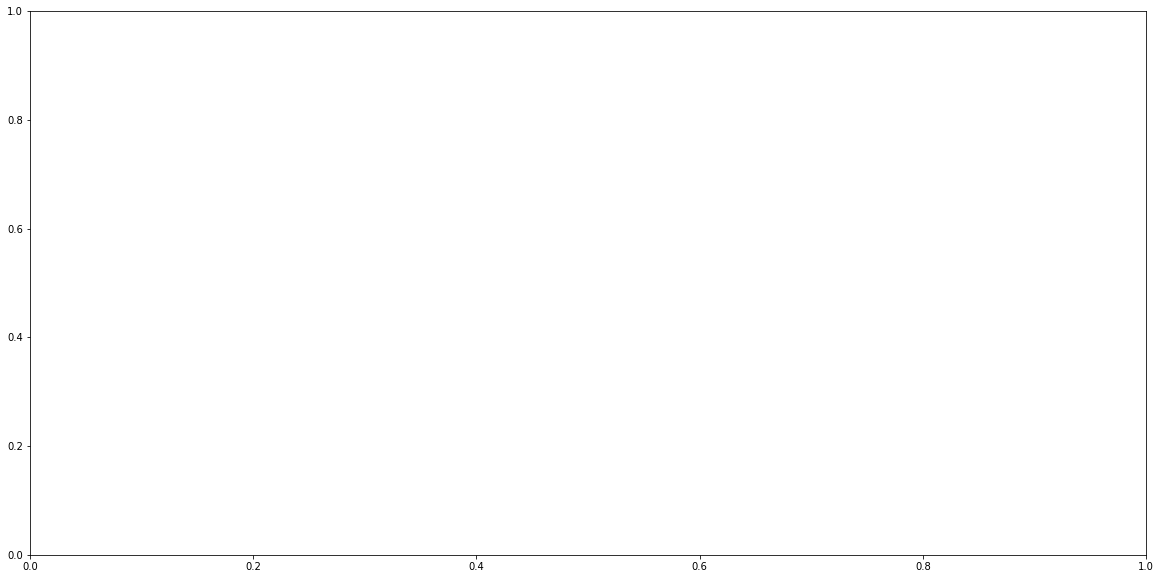

In [34]:
with torch.no_grad():
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        print('wts', layer_1_neurons['wts'])
        print('input',np.reshape(inputs,(2, 2400)))
        print('dot prod', np.dot(layer_1_neurons['wts'], np.reshape(inputs,(2, 2400))))
        print('bias', np.repeat(np.reshape(layer_1_neurons['bias'],(4,1)), 2400,axis=1).numpy())
        
        layer_1_output = np.dot(layer_1_neurons['wts'], np.reshape(input,(2, 2400)))+ \
                         np.repeat(np.reshape(layer_1_neurons['bias'],(4,1)), 2400,axis=1).numpy()
        print(layer_1_output)
        layer_1_output = F.relu(torch.from_numpy(layer_1_output))
        print(layer_1_output)


        for i in [0,1,2,3]:
            fig,ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(20,10))

            neuron_1 = layer_1_output[:,i]
            non_zero_index = np.where(neuron_1 == 0)[0]
            sns.scatterplot(x=input[non_zero_index,0], y=input[non_zero_index,1],hue=labels[non_zero_index], 
                            palette=['tab:blue', 'tab:orange'], ax=ax)
            plt.show()
            plt.close()

        layer_2_output = np.dot(layer_2_neurons['wts'], np.reshape(layer_1_output,(4, 2400))).reshape(2400,10)+ \
                         np.repeat(np.reshape(layer_2_neurons['bias'],(1,10)), 2400,axis=0).numpy()
        layer_2_output = F.softmax(torch.from_numpy(layer_2_output), dim=1)

        fig,ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(20,10))

        legend_labels = []
        for i in range(0, 10):

            neuron = layer_2_output[:,i]
            non_zero_index = np.where(neuron > 0.5)[0]
            sns.scatterplot(x=input[non_zero_index,0], y=input[non_zero_index,1],ax=ax)
            legend_labels.append('neuron_'+str(i+1))
        plt.legend(legend_labels)
        plt.show()
        plt.close()

        print(layer_2_output.shape)
        experts = np.argmax(layer_2_output, axis=1)
        print(experts)

        fig,ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(20,10))
        sns.scatterplot(x=input[:,0], y=input[:,1],hue=experts,ax=ax)

            #plt.show()
            #plt.close()



In [32]:
input

tensor([[-0.1723,  0.7872],
        [-0.1584, -0.9155],
        [-0.0189,  0.6703],
        ...,
        [ 0.1083,  0.8197],
        [ 0.6013, -0.3653],
        [-0.0655, -0.1471]])

tensor([1, 2, 1,  ..., 1, 2, 2])


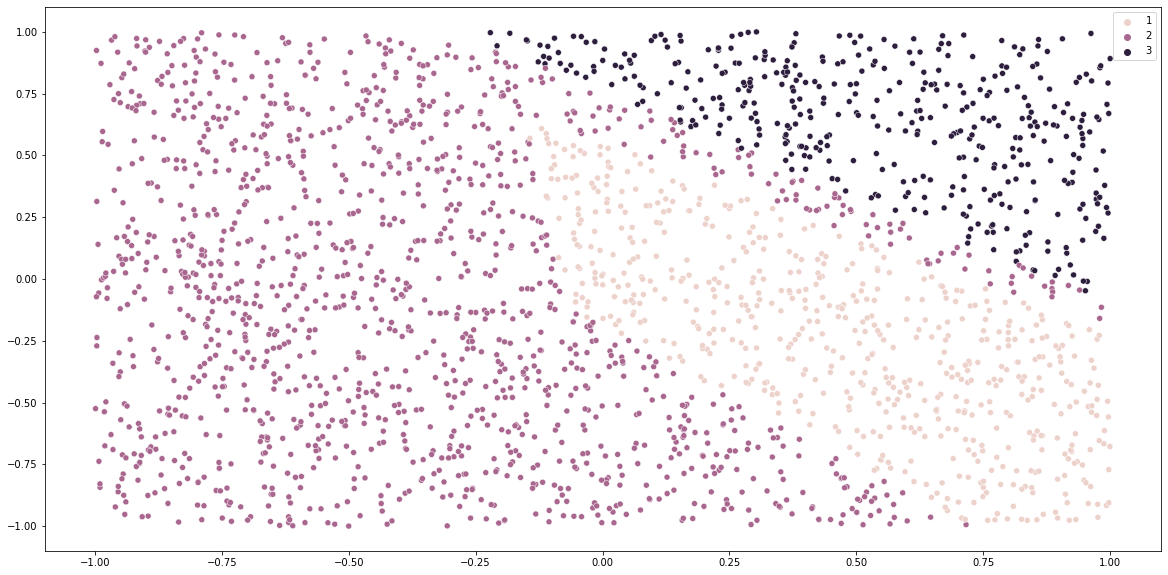

In [49]:
moe_model = models['moe_stochastic_model']['experts'][10]['model']
for i, data in enumerate(trainloader, 0):
    input, labels = data
    with torch.no_grad():
        layer_2_output = moe_model.gate(input)
        experts = np.argmax(layer_2_output, axis=1)
        print(experts)

        fig,ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(20,10))
        sns.scatterplot(x=input[:,0], y=input[:,1],hue=experts,ax=ax)


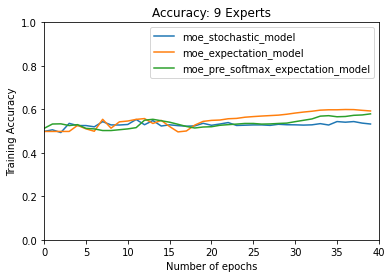

In [28]:
labels = []
for m_key, m_val in models.items():
    history = m_val['experts'][10]['hist']
    plt.plot(range(len(history['accuracy'])), history['accuracy'])
    labels.append(m_key)
plt.title('Accuracy: ' + str(i) + ' Experts')
plt.legend(labels)
plt.xlabel('Number of epochs')
plt.xlim(0, num_epochs)
plt.ylabel('Training Accuracy')
plt.ylim(0, 1)
plt.savefig('figures/all/accuracy_'+dataset+'_'+str(num_classes)+'_'+str(i)+'_experts.png')
plt.show()